<center> <h1>Homework 7 | DATA 5600</h1> </center>
<center> <h2>Logistic Regression</h2> </center>
<center> <h3> Dallin Moore <h3> <center>

In [5]:
# load packages here
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score

#set seed
import random
random.seed(5600)

# hide warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

## Data and Description

Type 2 diabetes is a problem with the body that causes blood sugar levels to rise higher than normal (hyperglycemia) because the body does not use insulin properly. Specifically, the body cannot make enough insulin to keep blood sugar levels normal. Type 2 diabetes is associated with various health complications such as neuropathy (nerve damage), glaucoma, cataracts and various skin disorders. Early detection of diabetes is crucial to proper treatment so as to alleviate complications.

The data set contains information on 392 randomly selected women who are at risk for diabetes. The data set contains the following variables:

| Variable  | Description                                                                        |
|-----------|------------------------------------------------------------------------------------|
| pregnant  | Number of times pregnant                                                           |
| glucose   | Plasma glucose concentration at 2 hours in an oral glucose tolerance test          |
| diastolic | Diastolic blood pressure (mm Hg)                                                   |
| triceps   | Triceps skin fold thickness (mm)                                                   |
| insulin   | 2 hour serum insulin (mu U/ml)                                                     |
| bmi       | Body mass index ($kg/m^2$, mass in kilograms divided by height in meters-squared)  |
| pedigree  | Numeric strength of diabetes in family line (higher numbers mean stronger history) |
| age       | Age                                                                                |
| diabetes  | Does the patient have diabetes (0 if "No", 1 if "Yes")                             |

The data can be found in the Diabetes data set on Canvas. Download Diabetes.txt, and put it in the same folder as this file.


#### 1. Read in the data set, call it "dia", and remove the "row" column. Print a summary of the data or the top few rows, and make sure the data makes sense.

In [6]:
dia = pd.read_csv('Diabetes.txt', sep=' ', index_col=0)
dia.head()

,pregnant,glucose,diastolic,triceps,insulin,bmi,pedigree,age,diabetes
row,,,,,,,,,
1,1,89,66,23,94,28.1,0.167,21,0
2,0,137,40,35,168,43.1,2.288,33,1
3,3,78,50,32,88,31.0,0.248,26,1
4,2,197,70,45,543,30.5,0.158,53,1
5,1,189,60,23,846,30.1,0.398,59,1


#### 2. Print out the number of women who have diabetes and who do not have diabetes. [1 point]

In [7]:
# number of women with diabetes and without diabetes
dia['diabetes'].value_counts()

diabetes
0    262
1    130
Name: count, dtype: int64

#### 3. Explore the data. Create a color-coded correlation matrix for the covariates. *Comment on why or why not you think multicollinearity may be a problem for this data set.* [1 point]

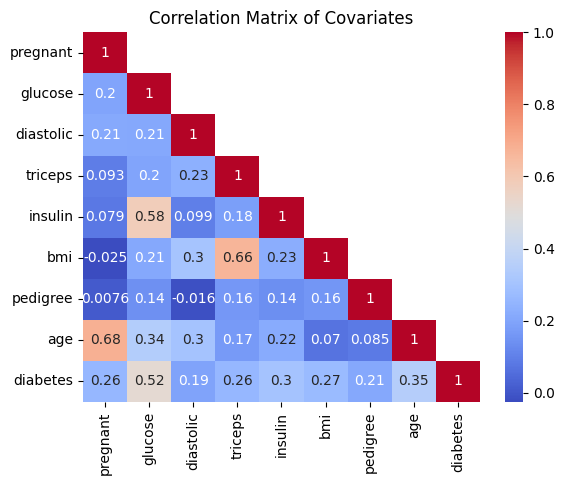

In [8]:
# color coded correlation matrix for the covariates with values
sns.heatmap(dia.corr(), cmap='coolwarm', annot=True, mask=np.triu(dia.corr(), k=1))
plt.title('Correlation Matrix of Covariates')
plt.show()

The most worrying values to consider are those above 0.5. For this array, that means the relationship between `triceps` and `bmi`, `pregnant` and `age`, and `glucose` and `insulin`. Considering the healthy individual fallacy that is often present in tests like this, I'm surprised there isn't more correlation between variables, but there still could be multicollinearity present.



#### 4. Explore the data. Create boxplots of the response against the following predictors: glucose, bmi, pedigree, and age (4 plots in total). You may want to use the `plt.subplots` function from the `matplotlib` package to display them in a 2x2 grid. *Briefly comment on one interesting trend you observe.* [1 point]

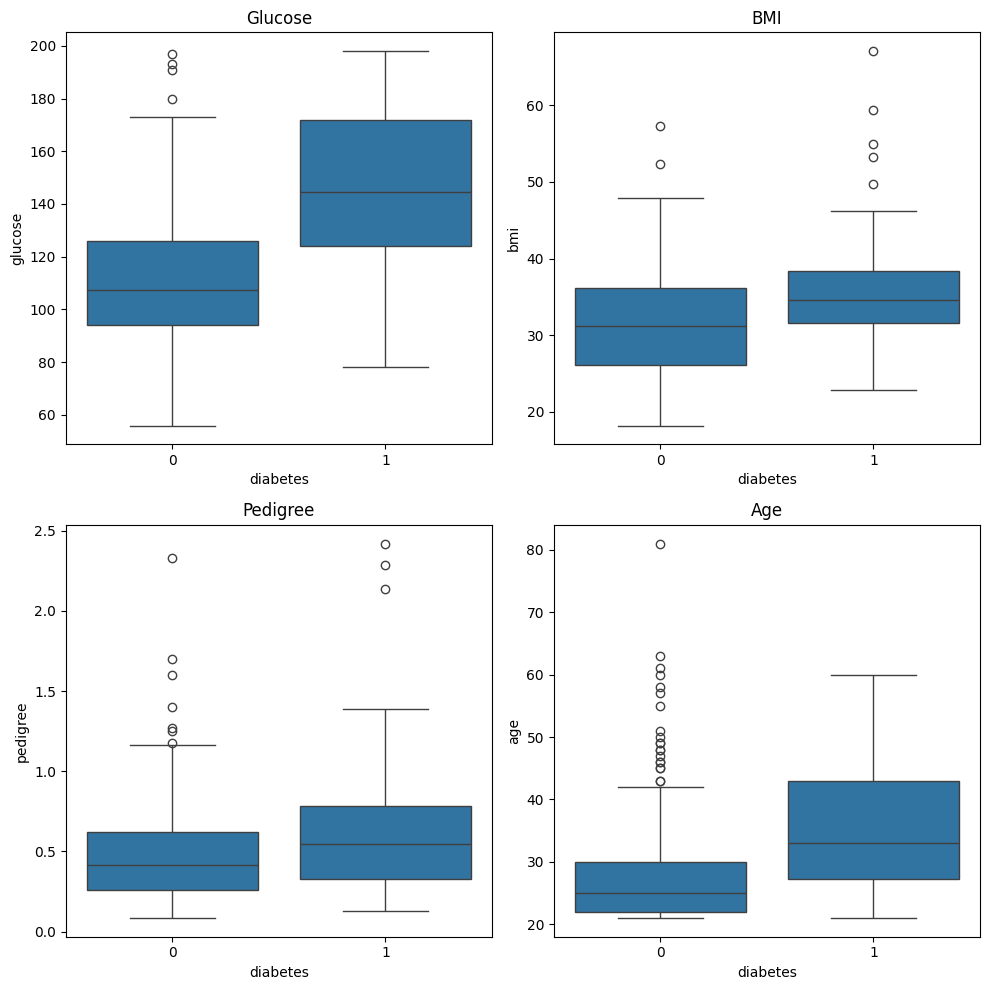

In [9]:
# Create boxplots of the response against the following predictors: glucose, bmi, pedigree, and age (4 plots in total). You may want to use the `plt.subplots` function from the `matplotlib` package to display them in a 2x2 grid.
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
sns.boxplot(x='diabetes', y='glucose', data=dia, ax=axs[0, 0])
axs[0, 0].set_title('Glucose')
sns.boxplot(x='diabetes', y='bmi', data=dia, ax=axs[0, 1])
axs[0, 1].set_title('BMI')
sns.boxplot(x='diabetes', y='pedigree', data=dia, ax=axs[1, 0])
axs[1, 0].set_title('Pedigree')
sns.boxplot(x='diabetes', y='age', data=dia, ax=axs[1, 1])
axs[1, 1].set_title('Age')
plt.tight_layout()
plt.show()

An interesting trend to note is just how much tighter the box plot is for `bmi` of people with diabetes versus those without. The average is higher for diabetes, but the IQR is within the IQR for `bmi` of those without diabetes.


#### 5. Explore the data. Create a color-coded scatterplot of bmi vs glucose colored by diabetes. *Briefly comment on what you observe.* [1 point]

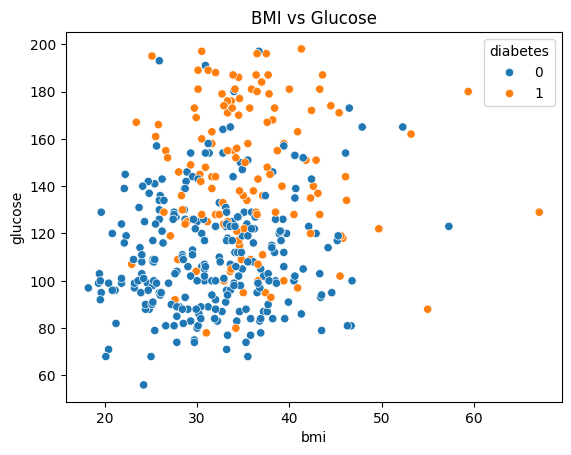

In [10]:
# Create a color-coded scatterplot of bmi vs glucose colored by diabetes
sns.scatterplot(x='bmi', y='glucose', hue='diabetes', data=dia)
plt.title('BMI vs Glucose')
plt.show()

There aren't apparent linear trends with the data, but looking at a quadrant of the data where `glucose` is less than 100 and `bmi` is less than 30, there are a lot of non-diabetes points and only one diabetes-positive point indicating the combination of `bmi`<30 and `glucose`<100 gives you very low chance of diabetes.


#### 6. Briefly explain one reason why traditional multiple linear regression methods are not suitable for this data set. [1 point]


The dataset does not have a continuous outcome variable, it is binary so logistic regression is a must./

#### 7. Split the data set into train and test sets using an 80/20 split. [1 point]

In [11]:
# Split the data set into train and test sets using an 80/20 split.
X = dia.drop(columns='diabetes')
y = dia['diabetes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5600)


#### 8. *Using the training data set*, apply one variable selection procedure to help you decide which, if any, variables to omit from the logistic regression model. You may choose which selection method to use (best subsets, backward, or sequential replacement). Use "accuracy" for the scoring metric. Write out the names of the variables you will include in your model. [1 point]

In [12]:
# use best subset selection to find the best subset of features
best_subsets_selection = EFS(LogisticRegression(fit_intercept = True,
                                                max_iter = 1000,
                                                penalty = None), 
                             min_features = 1,
                             max_features = len(X_train.columns),
                             scoring = 'accuracy',
                             print_progress = False,
                             cv = 10)

best_subsets = best_subsets_selection.fit(X_train, y_train)

print('Best subset:', best_subsets.best_feature_names_)

Best subset: ('glucose', 'insulin', 'pedigree', 'age')


Based on best subsets, the only variables that will be kept are `glucose`, `insulin`, `pedigree`, and `age`.

#### 9. Write out the general/theoretical logistic regression model for this data set using the covariates that you chose in the previous question. You should use parameters/Greek letters (NOT the "fitted" model using numbers...since you have not fit a model yet;)). [3 points]

$
\text{logit}(\text{diabetes}_i) = \log\left(\frac{P(\text{diabetes}_i = 1)}{P(\text{diabetes}_i = 0)}\right) = \beta_0 + \beta_1 \cdot \text{glucose}_i + \beta_2 \cdot \text{insulin}_i + \beta_3 \cdot \text{pedigree}_i + \beta_4 \cdot \text{age}_i 
$




#### 10. Fit a logistic regression model using the covariates you chose. Print a summary of the results. [1 point]

In [13]:
# Fit a logistic regression model using 'glucose', 'insulin', 'pedigree', 'age'. Print a summary of the results.
X_train_subset = X_train[['glucose', 'insulin', 'pedigree', 'age']]
X_train_subset = sm.add_constant(X_train_subset)
logit_model = sm.Logit(y_train, X_train_subset)
result = logit_model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.437351
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               diabetes   No. Observations:                  313
Model:                          Logit   Df Residuals:                      308
Method:                           MLE   Df Model:                            4
Date:                Tue, 19 Nov 2024   Pseudo R-squ.:                  0.3046
Time:                        18:34:56   Log-Likelihood:                -136.89
converged:                       True   LL-Null:                       -196.84
Covariance Type:            nonrobust   LLR p-value:                 5.627e-25
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.2509      0.928     -8.892      0.000     -10.070      -6.432
glucose        0.0390      0.006      6.246      0.000       0.027       0.051
insulin        0.0004      0.001      0.316      0.752      -0.002       0.003
pedigree       1.6415      0.484      3.388      0.001       0.692       2.591
age            0.0498      0.016      3.166      0.002       0.019       0.081
==============================================================================
"""

### Questions 11-15 involve using diagnostics to check the logistic regression model assumptions. For each assumption, (1) code the diagnostic(s) that I indicate (next to the assumption in parentheses) to determine if the assumption is violated, and (2) explain whether or not you think the assumption is violated and *why* you think that.


#### 11. The X's vs log odds are linear (monotone in probability) (Use scatterplots with smoothers - `sm.nonparametric.lowess`) [1 point]

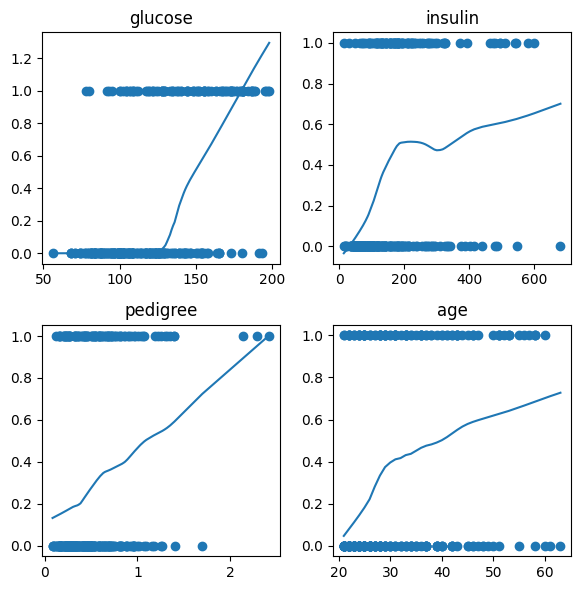

In [14]:
fig, ax = plt.subplots(2, 2, figsize = (6, 6))

out = sm.nonparametric.lowess(y_train, X_train_subset['glucose'])
ax[0, 0].scatter(y = y_train, x = X_train_subset['glucose'])
ax[0, 0].plot(out[:, 0], out[:, 1])
ax[0, 0].set_title("glucose")

out = sm.nonparametric.lowess(y_train, X_train_subset['insulin'])
ax[0, 1].scatter(y = y_train, x = X_train_subset['insulin'])
ax[0, 1].plot(out[:, 0], out[:, 1])
ax[0, 1].set_title("insulin")

out = sm.nonparametric.lowess(y_train, X_train_subset['pedigree'])
ax[1, 0].scatter(y = y_train, x = X_train_subset['pedigree'])
ax[1, 0].plot(out[:, 0], out[:, 1])
ax[1, 0].set_title("pedigree")

out = sm.nonparametric.lowess(y_train, X_train_subset['age'])
ax[1, 1].scatter(y = y_train, x = X_train_subset['age'])
ax[1, 1].plot(out[:, 0], out[:, 1])
ax[1, 1].set_title("age")

plt.tight_layout()
plt.show()

The linearity assumption seems reasonably well met for glucose and pedigree, but insulin and possibly age may not meet the assumption.

#### 12. The observations are independent (no diagnostic tools - just think about how the data was collected and briefly write your thoughts) [1 point]



Since the dataset claims random selection, independence of observations can be assumed.



#### 13. The model describes all observations (i.e., there are no influential points) (Use DFFITS) [1 point]

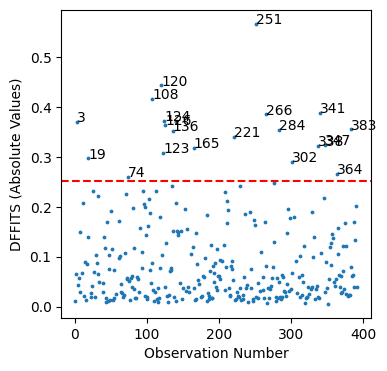

In [ ]:
# DFFITS
X_train_subset['dffits'] = result.get_influence().summary_frame()['dffits_internal']

# plot DFFITS against the observation number
fig = plt.figure(figsize = (4, 4))
plt.ylabel("DFFITS (Absolute Values)")
plt.xlabel("Observation Number")
plt.scatter(X_train_subset.index, np.abs(X_train_subset['dffits']), s = 3)
plt.axhline(y = 2 * np.sqrt(len(result.params) / len(X_train_subset)), color = 'r', linestyle = 'dashed')

#OPTIONAL: code to grab potential outliers
outliers = X_train_subset[np.abs(X_train_subset['dffits']) > 2 * np.sqrt(len(result.params) / len(X_train_subset))]
for i in list(outliers.index):
        plt.annotate(str(i), (i, np.abs(X_train_subset['dffits'][i])))
plt.show()

While there are number of observations above the threshold line, none of them are that high (the maximum is barely double the threshold) and the are evenly distributed across the observation numbers.


#### 14. Additional predictor variables are not required (no diagnostic tools - just think about the variables you have and if there are other variables you think would help predict the response) [1 point]


While things like diet and physical activity habits may be make a difference we will assume that there are not.


#### 15. No multicollinearity (Use variance inflation factors) [1 point]

In [19]:
chd_logistic_vifs = pd.DataFrame()
chd_logistic_vifs['Feature'] = X_train_subset.columns[1:6]
chd_logistic_vifs['VIF'] = [vif(X_train_subset, i) for i in range(1, len(X_train_subset.columns[0:6]))]

print("Max = ", max(chd_logistic_vifs['VIF']))
print("Mean = ", np.mean(chd_logistic_vifs['VIF']))
chd_logistic_vifs

Max =  1.6431224076623703
Mean =  1.3795938099340614


,Feature,VIF
0,glucose,1.643122
1,insulin,1.584546
2,pedigree,1.020003
3,age,1.193745
4,dfbetas_glucose,1.456554


All values below 2 is good to see, the assumption is met.


#### 16. Briefly comment on if all assumptions are met. We will move forward with the data set as-is, but if there is something you would want to do before proceeding to statistical inference, explain what that would be. [1 point]

The assumption of X's vs. Log-odds being linear was not met. Transforming `insulin` with log-transformation or categorization may help satisfy the assumptions.

#### 17. For the coefficient for pedigree, compute (and output) the log odds ratio ($\beta_{pedigree}$, pull this value from the model output), odds ratio ($\exp\{\beta_{pedigree}\}$), and the odds ratio converted to a percentage ($100 \times (\exp\{\beta_{pedigree}\} - 1)%$). *If you did not include pedigree in your model, just pick a variable you did include instead.* [3 points]

In [22]:
# log odds ratio: 
lor = result.params['pedigree']
print("log odds ratio:",lor)

# odds ratio:
print("odds ratio:",np.exp(lor))

# odds ratio converted to a percentage
print("odds ratio converted to a percentage", 100 * (np.exp(lor) - 1))

log odds ratio: 1.6414739613648652
odds ratio: 5.1627736356404
odds ratio converted to a percentage 416.27736356404006


#### 18. Interpret the coefficient for pedigree based on the FOUR different ways we discussed in class. *If you did not include pedigree in your model, use the same variable you chose in the previous question.* [4 points]


*Interpretation 1:* The *log-odds coefficient* of *1.641* means that for a one-unit increase in the `pedigree` score, the *log-odds* of having diabetes increase by *1.641*, holding all other predictors constant.  


*Interpretation 2:* The *odds ratio* of *5.163* means that for a one-unit increase in the `pedigree` score, the odds of having diabetes are multiplied by approximately *5.16*, assuming all other predictors remain constant.  


*Interpretation 3:* The *odds ratio converted to a percentage* (416.28%) means that for a one-unit increase in the `pedigree` score, the odds of having diabetes increase by *416.28%*, holding all other predictors constant.  


*Interpretation 4:* The positive sign of the coefficient indicates that a higher `pedigree` score increases the likelihood of having diabetes. The relatively large magnitude of the odds ratio (5.163) suggests that `pedigree` is a strong predictor of diabetes risk.


#### 19. Create (and output) 95% confidence intervals for $\beta_{glucose}$, $\exp\{\beta_{glucose}\}$, and $100 \times (\exp\{\beta_{glucose}\} - 1)%$ for glucose using the `conf_int` function. *If you did not include glucose in your model, just pick a variable you did include instead.* [3 points]

In [ ]:
# Create (and output) 95% confidence intervals for $\beta_{glucose}$, $\exp\{\beta_{glucose}\}$, and $100 \times (\exp\{\beta_{glucose}\} - 1)%$ for glucose using the `conf_int` function.

intervals = result.conf_int().iloc[1, :]
print(f"95% confidence interval for glucose: ({intervals.iloc[0]:.2f}, {intervals.iloc[1]:.2f})")
print(f"95% confidence interval for exp(beta_glucose):({np.exp(intervals).iloc[0]:.2f}, {np.exp(intervals).iloc[1]:.2f})")
print(f"95% confidence interval for 100 * (exp(beta_glucose) - 1)%: ({100 * (np.exp(intervals) - 1).iloc[0]:.2f}, {100 * (np.exp(intervals) - 1).iloc[1]:.2f})")


95% confidence interval for glucose: (0.03, 0.05)
95% confidence interval for exp(beta_glucose):(1.03, 1.05)
95% confidence interval for 100 * (exp(beta_glucose) - 1)%: (2.71, 5.26)


#### 20. Interpret the three 95% confidence intervals for glucose you found in the previous question (three interpretations total). *If you did not include glucose in your model, use the same variable you chose in the previous question.* [3 points]


*Interpretation 1:* The 95% confidence interval for $ \beta_{\text{glucose}}\ $  of (0.03, 0.05) indicates that for a one-unit increase in glucose, the log-odds of the outcome increase by a value between 0.03 and 0.05, with 95% confidence. Since the interval is entirely positive, glucose is a statistically significant predictor of the outcome.


*Interpretation 2:* The 95% confidence interval for $ e^{\beta_{\text{glucose}}}\ $  of (1.03, 1.05) indicates that for a one-unit increase in glucose, the odds of the outcome increase by a factor between 1.03 and 1.05 (a 3% to 5% increase in odds), with 95% confidence. Since the interval is above 1, glucose is positively associated with the outcome.


*Interpretation 3:* The 95% confidence interval for $ (100 \times (e^{\beta_{\text{glucose}}} - 1)% $  of (2.71%, 5.26%) indicates that for a one-unit increase in glucose, the odds of the outcome increase by between 2.71% and 5.26%, with 95% confidence. This expresses the effect of glucose on the odds of the outcome in more intuitive percentage terms.


#### 21. Calculate a 95% confidence interval for the predicted probability that a patient has diabetes where pregnant = 1, glucose = 90, diastolic = 62, triceps = 18, insulin = 59, bmi = 25.1, pedigree = 1.268 and age = 25. Note that you may not need to use all of these values depending on the variables you chose to include in your model. *Do you think this patient will develop diabetes? Why or why not?* [2 points]

In [30]:
pred = result.get_prediction([1, 90, 59, 1.268, 25], which = 'linear')
pred.summary_frame(alpha = 0.05)

,predicted,se,ci_lower,ci_upper
0,-1.387463,0.428893,-2.228077,-0.546849


No, this patient is unlikely to develop diabetes. The predicted log-odds of -1.387 suggest a low likelihood of the outcome, and the entire 95% confidence interval for the log-odds (-2.228 to -0.547) is negative, meaning the probability of developing diabetes is low.

#### 22. What is the $p$-value of the likelihood ratio test (aka deviance, aka model chi-squared)? (You can copy/paste this from the model summary output from question 10). What does this $p$-value tell you? [2 points]

The $p$-value of the log likelihood ratio test is 5.627e-25. The predictors in the model provide strong evidence for explaining the outcome (diabetes), and the model is highly significant.

#### 23. What is the best cutoff value for the model that minimizes the percent misclassified? Show your code and output the best cutoff value. [1 point]

In [31]:
possible_cutoffs = np.linspace(0, 1, 100)
percent_misclass = np.ones(100)
predicted_probabilities = np.exp(result.fittedvalues) / (1 + np.exp(result.fittedvalues))
    
for i in range(len(possible_cutoffs) - 1):
  cutoff = possible_cutoffs[i]
  classify = (predicted_probabilities > cutoff).astype(int)
  percent_misclass[i] = np.mean((classify != y_train.astype(int)).astype(int))

cutoff = possible_cutoffs[np.argmin(percent_misclass)]
cutoff

0.5555555555555556

#### 24. Create (and output) a confusion matrix FOR THE TEST DATA SET using the best cutoff value you found above. [1 point]

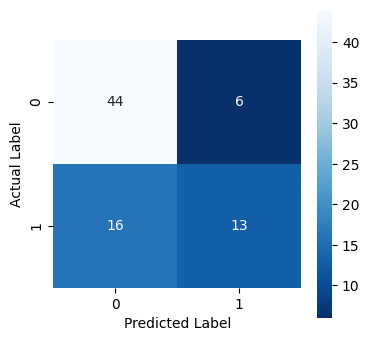

In [32]:
# Create (and output) a confusion matrix FOR THE TEST DATA SET using the best cutoff value you found above.
X_test_subset = sm.add_constant(X_test[['glucose', 'insulin', 'pedigree', 'age']])
pred_probs_test = result.predict(X_test_subset)
# Use the cutoff to get predicted classifications of 0/1
preds_test = (pred_probs_test > cutoff).astype(int)
# Get confusion matrix
conf_mat = confusion_matrix(y_test, preds_test)
# Confusion matrix with labels
plt.figure(figsize = (4, 4))
sns.heatmap(conf_mat, 
            annot = True, 
            fmt = ".0f", 
            square = True, 
            cmap = 'Blues_r')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

#### 25. Based on the confusion matrix, calculate (and output) the value for the specificity. What does the specificity measure in context of this data set? [1 point]

In [33]:
# specificity
conf_mat[0, 0] / np.sum(conf_mat[0, :])

0.88

The sensitivity of 0.88 for the model means that it correctly identifies 88% of patients who have diabetes (true positives) from the dataset. A sensitivity of 0.88 is high, indicating the model performs well at identifying patients with diabetes.


#### 26. Based on the confusion matrix, calculate (and output) the value for the sensitivity. What does the sensitivity measure in context of this data set? [1 point]

In [34]:
# sensitivity
conf_mat[1, 1] / np.sum(conf_mat[1, :])

0.4482758620689655

The specificity of 0.448 means that your model correctly identifies only 44.8% of patients who do not have diabetes (true negatives) from the dataset. A specificity of 44.8% is relatively low, indicating the model often misclassifies non-diabetic patients as diabetic (false positives).


#### 27. Based on the confusion matrix, calculate (and output) the percent correctly classified (accuracy). What does the percent correctly classified measure in context of this data set? [1 point]

In [35]:
# accuracy
np.sum(np.diag(conf_mat)) / np.sum(conf_mat)

0.7215189873417721

72.15% of all patients (both diabetic and non-diabetic) were correctly classified by the model.

#### 28. What is the AUC FOR THE TEST DATA? [1 point]

In [36]:
# auc
roc_auc_score(y_test, pred_probs_test)

0.8020689655172414


#### 29. Briefly summarize what you learned from this analysis *to a non-statistician*. Write a few sentences about (1) the purpose of this data set and analysis and (2) what you learned about this data set from your analysis. Write your response as if you were addressing a business manager (avoid using statistics jargon) and just provide the main takeaways. [1 point]



The purpose of this analysis was to assess the likelihood of women developing diabetes based on various health factors, such as glucose levels, age, and body mass index. We used a model to predict whether a patient will develop diabetes based on these factors.

From the analysis, we learned that the model is good at identifying patients who are at high risk for diabetes, with high accuracy in detecting true cases. However, it also has some challenges in accurately ruling out patients who are not at risk, which could result in some false positives. Overall, the model is effective, but improvements could be made to better distinguish between those with and without diabetes, especially to reduce unnecessary follow-up for non-diabetic patients.